# Quality Control

## Motivation

A crucial part of every single-cell analysis is the removal of low-quality cells which can distort downstream analyses outcomes. scATAC-seq data, having only 1-10% of open chromatin regions detected in each cell, is even more sparse than scRNA-seq data {cite}`atacqc:chen_assessment_2019`. Therefore, quality issues such as low sequencing depth per cell or poor signal-to-noise ratio can lead to uninformative observations (cells). Another challenge is the detection of multiplets (two or more cells profiled together). In the following chapter, we will introduce metrics for quality control (QC) of scATAC-seq data and introduce doublet detection methods.

## Dataset

To showcase the processing of scATAC-seq data, we use a 10x Multiome data set generated for the single cell data integration challenge at the NeurIPS conference 2021 {cite}`atacqc:luecken2021sandbox`. Note that this data set contains multiple samples, making feature harmonization and integration important to consider before analysing them jointly (discussed in later chapters). However, the most unbiased quality assessment can be derived by examining each sample individually. Therefore, we describe the preprocessing of one selected sample in this notebook.

Our starting point is the output of `cellranger-arc`, the software solution of 10x to perform alignment, peak calling and initial QC of their 10x Multiome assay. By default, the output files contain the snRNA-seq and the scATAC-seq data. Since the preprocessing of scRNA-seq or snRNA-seq data has been described extensively in previous chapters, here, we only discuss the processing of the chromatin accessibility data (which are also applicable to data from a unimodal scATAC-seq assay).


The primary file we load is the `filtered_feature_bc_matrix.h5` file containing the cell-by-peak count matrix. During loading, we leverage the functionality of `moun` to automatically detect the corresponding fragment and peak annotation files within the same directory.

To get started, we import all required Python packages.

In [10]:
# Single-cell packages
import anndata2ri
import matplotlib.pyplot as plt
import muon as mu
import numpy as np

# General helpful packages for data analysis and visualization
import pandas as pd
import scanpy as sc
import seaborn as sns
from muon import atac as ac  # the module containing function for scATAC data processing

# Packages enabling to run R code
from rpy2.robjects import pandas2ri

pandas2ri.activate()  # Automatically convert rpy2 outputs to pandas DataFrames
anndata2ri.activate()
%load_ext rpy2.ipython


# Setting figure parameters
sc.settings.verbosity = 0
sns.set(rc={"figure.figsize": (4, 3.5), "figure.dpi": 100})
sns.set_style("whitegrid")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [4]:
mdata = mu.read_10x_h5("cellranger_out/filtered_feature_bc_matrix.h5")

/Users/christopher.lance/mambaforge/envs/scatac_pp/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from resources/cellranger_out/filtered_feature_bc_matrix.h5


/Users/christopher.lance/mambaforge/envs/scatac_pp/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/christopher.lance/mambaforge/envs/scatac_pp/lib/python3.9/site-packages/mudata/_core/mudata.py:446: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


Added peak annotation from resources/cellranger_out/atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: resources/cellranger_out/atac_fragments.tsv.gz


As the warning messages indicate, peak identifiers are not unique. To prevent issues in downstream analysis steps, we make them unique using the `.var_names_make_unique()` method.

In [5]:
mdata.var_names_make_unique()

Let's take a look into the `MuData` object we just generated.

In [6]:
mdata

MuData object with n_obs × n_vars = 16934 × 190628
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	16934 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	16934 x 154027
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

Both modalities (RNA and ATAC) have been loaded as two `AnnData` objects. In total 16934 cells were loaded and 36601 genes and 154027 peaks for RNA and ATAC, respectively. The ATAC modality additionally contains two entries in the unstructured data slot `atac.uns` that contain the peak annotation and the path to the fragment file automatically located by `muon`.

Let's take a look at the `atac.uns` slot, printing the peak annotation and path to the fragment file.

In [7]:
mdata.mod["atac"].uns

OverloadedDict, wrapping:
	OrderedDict([('atac', {'peak_annotation':                                peak  distance peak_type
gene_name                                              
MIR1302-2HG         chr1:9763-10648    -18906    distal
AL627309.1       chr1:115270-116168      4764    distal
AL627309.5       chr1:181107-181768     -7246    distal
AL627309.5       chr1:183973-184845    -10112    distal
AL627309.5       chr1:191237-192111    -17376    distal
...                             ...       ...       ...
AC213203.2   KI270713.1:21361-22256     10272    distal
AC213203.2   KI270713.1:29645-30508      2020    distal
AC213203.2   KI270713.1:32401-33088         0  promoter
AC213203.1   KI270713.1:34369-35136      -271  promoter
AC213203.1   KI270713.1:36970-37884      1564    distal

[196633 rows x 3 columns]}), ('files', {'fragments': 'resources/cellranger_out/atac_fragments.tsv.gz'})])
With overloaded keys:
	['neighbors'].

The table generated from the peak annotation file gives a first idea which genes might be associated with a given peak. However, this is purely based on the distance to the closest gene and should be considered with care.

For subsequent processing we extract the `Anndata` object corresponding to the atac modality:

In [8]:
atac = mdata.mod["atac"]

## Doublet detection

The sparsity of scATAC data is considerably higher compared to scRNA-seq data. Therefore, it is not recommended to directly apply methods developed for scRNA-seq on scATAC-seq data. Here, we describe the use of two orthogonal methods for doublet scoring which can be used to detect clusters of cells containing doublets later on. Both approaches have been implemented in the R package scDoubletFinder {cite}`atacqc:germain2021doublet` and the following steps were adapted from [this tutorial](https://www.bioconductor.org/packages/devel/bioc/vignettes/scDblFinder/inst/doc/scATAC.html).

- **Approach 1: Doublet Scoring based on simulated doublets:** The native scDoubletFinder method is leveraging simulated doublets to assign doublet scores (see {ref}`rna:doublet-detection`). Prior to generating doublets, highly correlated features are aggregated to reduce sparsity and the number of features. As with methods for scRNA-seq data, this method detects heterotypic doublets (mix of different cell types).
- **Approach 2: Coverage-based doublet scoring using AMULET** {cite}`atacqc:thibodeau2021amulet`: Since DNA is only present as two copies in a diploid organism, one can expect a maximum count of two for any given position in the genome. AMULET makes use of this characteristic and evaluates the number of instances with more than two overlapping fragments for a given position (see figure below). An unexpected high number of such instances indicates a doublet (a small number of positions with more than two overlapping fragments is expected due to errors like duplication errors, sequencing and alignment errors or repetitive sequence content). AMULET performs best with a sufficient sequencing depth (> 10-15k reads per cell) and can capture heterotypic and homotypic doublets (identical cell type).

:::{figure-md} Amulet
<img src="../_static/images/sc_atac/amulet.png" alt="Amulet" class="bg-primary mb-1" width="800px">

Overview of AMULET approach.
:::

Before we run the doublet detection, let's make sure R uses the correct path to our installed environment.

In [12]:
%%R
.libPaths()

[1] "/Users/christopher.lance/mambaforge/envs/scatac_pp/lib/R/library"


Load the `scDblFinder` and `SingleCellExperiment` package.

In [13]:
%%R
suppressPackageStartupMessages(library(scDblFinder))
suppressPackageStartupMessages(library(SingleCellExperiment))

### Count distribution-based doublet scoring

Since the doublet scoring can take some time we specify a path and sample identifier to save the output.

In [9]:
# Set output paths
save_path_dir = "output/doublet_scores/"
sample_ident = "s4d8"

To enable the transfer of our data matrix to an `SingleCellExperiment` R object, we transpose (`.T`) and convert the sparse matrix in the `atac.X` slot into an array (`.A`). Additionally we save the barcodes as a separate list.

In [15]:
barcodes = list(atac.obs_names)
data_mat = atac.X.T.A

The `scDblFinder` methods works on a `SingleCellExperiment` object that we create from the our `data_mat` object. The user has to decide, whether doublet detection should happen cluster based (by using the `clusters` arguments) or using random cells. Cluster-based scoring is recommended if well-distinguishable cell populations are expected (e.g.PBMCs), while it is not recommended if continuous trajectories are expected. You can either provide pre-annotated clusters by specifying a vector of cluster labels for each cell, a metadata column of the `SingleCellExperiment` containing such labels, or `TRUE`. To not use clusters and randomly sample, one can set `clusters=FALSE` or `clusters=NULL`. 
As working with all features (peaks or bins) is computationally very expensive, the authors suggest to aggregate correlated features into a small set {cite}`atacqc:germain2021doublet`. This is enforced by setting `aggregateFeatures=TRUE`. This will aggregate peak or bin counts into `nfeatures` meta features. It is recommended to use a small number of features, we use 25. In a last step, the aggregated features are normalized `processing="normFeatures"` before calculation of the doublet scores.

In [16]:
%R -i data_mat -o dbl_score sce <- scDblFinder(SingleCellExperiment(list(counts=data_mat)), \
                                               clusters=TRUE, aggregateFeatures=TRUE, nfeatures=25, \
                                               processing="normFeatures"); dbl_score <- sce$scDblFinder.score

R[write to console]: dimnames(.) <- NULL translated to
dimnames(.) <- list(NULL,NULL)

R[write to console]: Aggregating features...

R[write to console]: Clustering cells...

R[write to console]: Warnung in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, 
R[write to console]: 
 
R[write to console]:  You're computing too large a percentage of total singular values, use a standard svd instead.

R[write to console]: 8 clusters

R[write to console]: Creating ~13548 artificial doublets...

R[write to console]: Dimensional reduction

R[write to console]: Evaluating kNN...

R[write to console]: Training model...

R[write to console]: iter=0, 2617 cells excluded from training.

R[write to console]: iter=1, 2725 cells excluded from training.

R[write to console]: iter=2, 2756 cells excluded from training.

R[write to console]: Threshold found:0.466

R[write to console]: 3038 (17.9%) doublets called

/Users/christopher.lance/mambaforge/envs/scatac_pp/lib/python3.9/sit

array([0.02819141, 0.00082514, 0.06341238, ..., 0.15534039, 0.02116382,
       0.12427134])

Based on the output messages about 18% of cells are suggested to be doublets. This might sound like a high fraction, but for the number of cells loaded for this sample and since isolated nuclei tend to stick together, this is reasonable.

Once the calculation is done, let's create a `pandas.DataFrame` containing the scores for all barcodes and save it as a file.

In [17]:
scDbl_result = pd.DataFrame({"barcodes": barcodes, "scDblFinder_score": dbl_score})
scDbl_result.to_csv(save_path_dir + "/scDblFinder_scores_" + sample_ident + ".csv")

In [18]:
scDbl_result.head()

,barcodes,scDblFinder_score
0,AAACAGCCAAGCTTAT-1,0.028191
1,AAACAGCCATAGCTTG-1,0.000825
2,AAACAGCCATGAAATG-1,0.063412
3,AAACAGCCATGTTTGG-1,0.026449
4,AAACATGCAACGTGCT-1,0.019928


To add the scores to our atac `AnnData` object, we set the barcodes as the index of the dataframe, which then matches the index of `adata.obs`.

In [11]:
scDbl_result = scDbl_result.set_index("barcodes")

Now we can add the column to `adata.obs`.

In [12]:
atac.obs["scDblFinder_score"] = scDbl_result["scDblFinder_score"]

### Coverage-based doublet scoring

As described before, AMULET estimates doublet scores based on the number of genomic positions with a fragment coverage higher two. Since this assumption is based on a diploid genome, we exclude mitochondrial genes (a cell can have many copies of the mitochondrial DNA) and sex chromosomes, as suggested by {cite}`atacqc:thibodeau2021amulet`. In addition, we want to mask repetitive sequences in the genome (e.g. interspersed nuclear elements or satellite repeats). To do so, we downloaded the `.bed` file provided with the AMULET publication available on [Zenodo](https://zenodo.org/record/5189588#.ZDlrwexBxqs) and load it with the R package `rtracklayer`, which directly creates a `GRanges` R object. Note that for this sample, with about 16k cells, AMULET takes about 4 hours to run on a personal computer (the `.bed` file of repeat elements and the AMULET output is also provided on figshare).

In [73]:
%%R

# Set up a GRanges objects of repeat elements, mitochondrial genes and sex chromosomes we want to exclude
suppressPackageStartupMessages(library(GenomicRanges))
suppressPackageStartupMessages(library(rtracklayer))

repeats =  import('resources/blacklist_repeats_segdups_rmsk_hg38.bed')
otherChroms <- GRanges(c("chrM","chrX","chrY","MT"),IRanges(1L,width=10^8)) # check which chromosome notation you are using c("M", "X", "Y", "MT")
toExclude <- suppressWarnings(c(repeats, otherChroms))

Furthermore, we need to define the path to the fragment file.

In [74]:
frag_path = atac.uns["files"]["fragments"]
frag_path

'resources/cellranger_out/atac_fragments.tsv.gz'

Now we are ready to run AMULET. Note that we input objects from our python environment and define outputs we use afterwards with the `-i` and `-o` tag following the `%R` magic, while the `toExclude` object is already available to the `amulet` function, since we generated it inside the R environment above. (In case you have a larger memory available, check out the `fullInMemory=TRUE` option for faster runtime.)

In [75]:
# Run AMULET
%R -i frag_path -o amulet_result amulet_result <- amulet(frag_path, regionsToExclude=toExclude)

# Save output
amulet_result.to_csv(save_path_dir + "/AMULET_scores_" + sample_ident + ".csv")

R[write to console]: 18:01:17 - Reading Tabix-indexed fragment file and computing overlaps



chr1, chr10, chr11, chr12, chr13, chr14, chr15, chr16, chr17, chr18, chr19, chr2, chr20, chr21, chr22, chr3, chr4, chr5, chr6, chr7, chr8, chr9, chrX, chrY, KI270728.1, KI270727.1, GL000009.2, GL000194.1, GL000205.2, GL000195.1, GL000219.1, KI270734.1, GL000213.1, GL000218.1, KI270731.1, KI270721.1, KI270726.1, KI270711.1, KI270713.1, 


R[write to console]: 22:20:44 - Merging



Let's have.a quick look at the output of AMULET.

In [17]:
amulet_result.head()

,nFrags,uniqFrags,nAbove2,total.nAbove2,p.value,q.value
AAACAGCCAAGCTTAT-1,1696.0,1696.0,0.0,0.0,0.994851,0.994851
AAACAGCCATGAAATG-1,2536.0,2536.0,0.0,1.0,0.994851,0.994851
AAACAGCCATGTTTGG-1,3464.0,3464.0,1.0,6.0,0.967723,0.994851
AAACATGCAACGTGCT-1,3602.0,3602.0,0.0,2.0,0.994851,0.994851
AAACATGCAATATAGG-1,3893.0,3893.0,1.0,3.0,0.967723,0.994851


For each barcode, we got the number of fragments, the number of sites covered by more than two fragments and the p- and q- values testing for the null hypothesis that a cell is a singlet. The lower the `q-value` the more likely the corresponding cell is a doublet. One could pick a common significance threshold to automatically define doublets, but we prefer to visualize the AMULET score later and look for populations of doublets manually.

We now add the scores to the `atac` object as well and transform them for nicer plotting.

In [14]:
atac.obs["AMULET_pVal"] = amulet_result["p.value"]
atac.obs["AMULET_qVal"] = amulet_result["q.value"]

In [15]:
# Transform q-values for nicer plotting
atac.obs["AMULET_negLog10qVal"] = -1 * np.log10(amulet_result["q.value"])

/Users/christopher.lance/mambaforge/envs/scatac_pp/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Let us now plot the scores we derived from the two approaches.

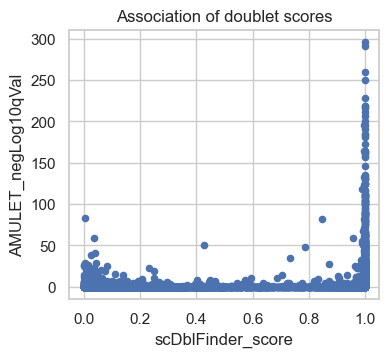

In [16]:
atac.obs.plot(x="scDblFinder_score", y="AMULET_negLog10qVal", kind="scatter")

plt.title("Association of doublet scores")
plt.show()

The scatter plot shows a comparison of the adjusted P-values from AMULET and the scDblFinder scores for each barcode. Points rising towards the top right quadrant of the plot represent barcodes where both methods score the cells as doublets. Points in the bottom left quadrant of the plot indicate barcodes where both AMULET and scDblFinder scores indicate valid cells. In the bottom right quadrant, points correspond to barcodes identified as doublets only by scDblFinder based on the count distribution. There are few dots higher up in the left quadrant, which are called doublets by AMULET but not scDblFinder which may correspond to homotypic doublets (only detected by AMULET but not with count-based methods). We plan to utilize both scores in a later step to identify clusters of doublets.

## Calculating QC metrics

To detect low quality cells, we need to define metrics, that allow us to separate high quality from low-quality cells. Here is an overview of the primary QC metrics used across multiple scATAC-seq processing pipelines:
- **total_fragment_counts**: Total number of fragments per cell representing cellular sequencing depth. This metric is analogous to the number of total counts in scRNA-seq data.
- **tss_enrichment**: Transcription start site (TSS) enrichment score, which is the ratio of fragments centered at the TSS to fragments in TSS-flanking regions. This metric can be interpreted as a signal-to noise ratio of each cell.
- **n_features_per_cell**: The number of peaks with non-zero counts in each cell. This metric is analogous to the number of genes detected in scRNA-seq data.
- **nucleosome_signal**: The nucleosome signal refers to the ratio of mono-nucleosomal to nucleosome-free fragments and can also be interpreted as a signal-to-noise ratio in each cell (more details below).

Additional metrics that can be considered:
- **reads_in_peaks_frac:** The fraction of fragments in peak regions versus fragments outside of peaks. Similar to the TSS score, this is an indicator for the signal-to-noise ratio.
- **blacklist_fraction:** The ratio of fragments in genomic blacklist regions, which have been associated with artefactual signal (defined by ENCODE). Benchmarking studies on processing of single-cell ATAC-seq data {cite}`atacqc:chen_assessment_2019` and based on our own experience, often the mapping of reads to blacklist regions is not a major issue single-cell data.

Besides cell-level QC metrics, we also recommend to assess sample-level quality, for instance, by assessing the number of detected cells per sample and comparing the distributions of cell-level metrics. For the later, a violin plots grouped by sample is very informative.


### Total fragment count and number of features

To get the first metrics, we make use of the `calculate_qc_metrics` function in scanpy to calculate the total number of fragments and number of features per cell. Since scanpy labels the metrics according to RNA-seq data, we modify the variable names to make them fit to scATAC-seq data, i.e. `total_counts` becomes `total_fragment_counts` and `n_genes_by_counts` becomes the more general `n_features_per_cell`. Additionally, we log-transform the `total_fragment_counts` which is often helpful for plotting.

In [17]:
# Calculate general qc metrics using scanpy
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

# Rename columns
atac.obs.rename(
    columns={
        "n_genes_by_counts": "n_features_per_cell",
        "total_counts": "total_fragment_counts",
    },
    inplace=True,
)

# log-transform total counts and add as column
atac.obs["log_total_fragment_counts"] = np.log10(atac.obs["total_fragment_counts"])

### Nucleosome signal

Next, we calculate scATAC specific QC metrics, the nucleosome signal and TTS enrichment score.

For the nucleosome signal, the default number of fragments `n` per cell used to calculate the metric is 10e4*n_cells. Since this takes long to calculate, we reduce it by a factor of 10, which still returns a good estimate. However, in a production pipeline we would still recommend to keep the default.

In [18]:
# Calculate the nucleosome signal across cells
# set n=10e3*atac.n_obs for rough estimate but faster run time
ac.tl.nucleosome_signal(atac, n=10e3 * atac.n_obs)

Reading Fragments: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169340000/169340000 [08:54<00:00, 317005.72it/s]


To better understand the metric, let's take a look at the overall distribution first.

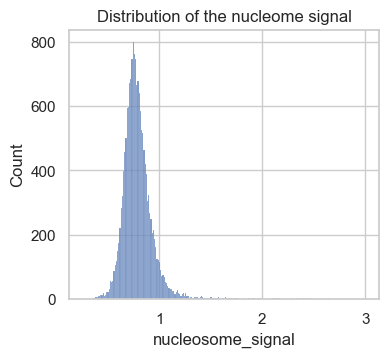

In [19]:
sns.histplot(atac.obs, x="nucleosome_signal")
plt.title("Distribution of the nucleome signal")
plt.show()

# Alternatively as a violin plot (uncomment to plot)
# sc.pl.violin(atac, "nucleosome_signal")

The obtained scores in this data set range from 0 to 3. As a rule of thumb, previous analysis projects chose a threshold between 2 and 4 to label low quality cells. Let's now take a closer look at cells with a high versus low nucleosome signal metric. To do so, we add a column to atac.obs, which contains a category for the two classes.

In [20]:
# Add group labels for above and below the nucleosome signal threshold
nuc_signal_threshold = 2
atac.obs["nuc_signal_filter"] = [
    "NS_FAIL" if ns > nuc_signal_threshold else "NS_PASS"
    for ns in atac.obs["nucleosome_signal"]
]

# Print number cells not passing nucleosome signal threshold
atac.obs["nuc_signal_filter"].value_counts()

NS_PASS    16877
NS_FAIL       57
Name: nuc_signal_filter, dtype: int64

In [21]:
atac.obs["nuc_signal_filter"]  # = atac.obs["nuc_signal_filter"].astype('category')

AAACAGCCAAGCTTAT-1    NS_PASS
AAACAGCCATAGCTTG-1    NS_PASS
AAACAGCCATGAAATG-1    NS_PASS
AAACAGCCATGTTTGG-1    NS_PASS
AAACATGCAACGTGCT-1    NS_PASS
                       ...   
TTTGTTGGTGGCTTCC-1    NS_PASS
TTTGTTGGTTCTTTAG-1    NS_PASS
TTTGTTGGTTGGCCGA-1    NS_PASS
TTTGTTGGTTTACTTG-1    NS_PASS
TTTGTTGGTTTGTGGA-1    NS_PASS
Name: nuc_signal_filter, Length: 16934, dtype: object

We can see, this sample only contains 57 barcodes with a higher nucleosome signal than 2.

Next, we plot the distribution of fragment lengths per group of cells. To speed up the generation of the plotting, we analyze fragments mapping to a certain region on chromosome 1 by setting `region="chr1:1-2000000"`.

Fetching Regions...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


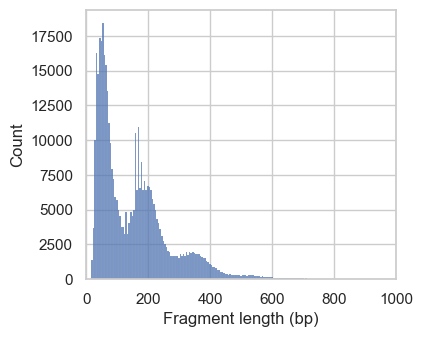

Fetching Regions...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


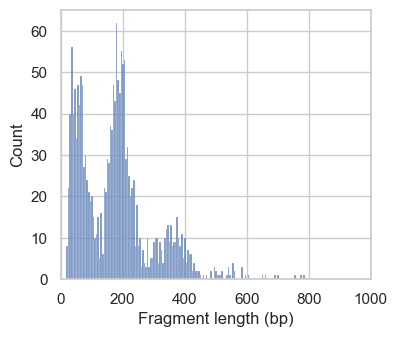

In [22]:
# Plot fragment size distribution
p1 = ac.pl.fragment_histogram(
    atac[atac.obs["nuc_signal_filter"] == "NS_PASS"], region="chr1:1-2000000"
)

p2 = ac.pl.fragment_histogram(
    atac[atac.obs["nuc_signal_filter"] == "NS_FAIL"], region="chr1:1-2000000"
)

In the first histograms, we see periodically decreasing peaks corresponding to fragment lengths in nucleosome-free regions (<100bp), mono-, di- and a small tri-nucleosomal length. In high quality ATAC-seq data we expect an enrichment of fragments from nucleosome-free regions compared to fragments with mono- and multi-nucleosomal lengths (this ratio is calculated as the nucleosome signal). In the second plot this ratio sub-optimal, and we exclude these cells. However, the low number of cells with a high nucleosome signal indicate that we are working with data with overall good quality.

### TSS enrichment

The next QC metric we assess is the signal-to-noise ratio in each cell. To do so, one can calculate the fraction of reads mapped to peak regions or the enrichment of fragments around transcription start sites (TSS). Here we use the later for assessing cell quality. To obtain a robust TSS score estimates while keeping compute time reasonably low, we set the number of randomly selected TSS to calculate the score to `n_tss=3000` (compared to the default of 2000).

In [52]:
tss = ac.tl.tss_enrichment(mdata, n_tss=3000, random_state=666)

Fetching Regions...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:44<00:00, 67.37it/s]


This creates a new `AnnData` object `tss`, which contains positions from -1000 to +1000 around each TSS as features. Additionally, a `tss_score` column is added to the ```atac.obs```  data frame.

Let's check the distribution of the full range of scores and with extreme outliers removed (up to the 99.5% percentile).

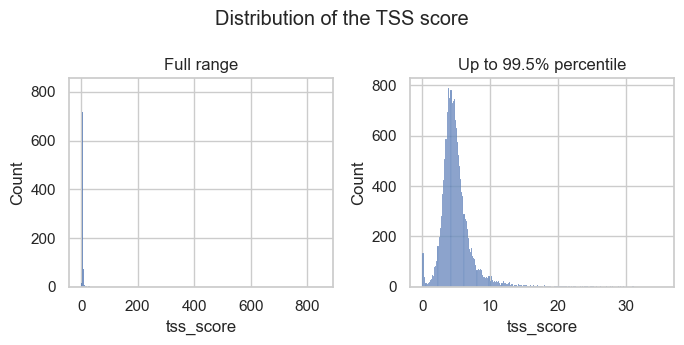

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))

p1 = sns.histplot(atac.obs, x="tss_score", ax=axs[0])
p1.set_title("Full range")

p2 = sns.histplot(
    atac.obs,
    x="tss_score",
    binrange=(0, atac.obs["tss_score"].quantile(0.995)),
    ax=axs[1],
)
p2.set_title("Up to 99.5% percentile")

plt.suptitle("Distribution of the TSS score")

plt.tight_layout()
plt.show()

The histograms show that there are a few outliers with extremely high TSS scores and a small peak of barcodes with low TSS scores. Both are observations we would like to filter out.

To understand the TSS score better, we plot the number of transposition events (fragment ends) up- and downstream of transcription start sites. We make use of the plotting function `ac.pl.tss_enrichment` available in muon and input the newly created `tss` object. To compare the enrichment profile corresponding to high and low TSS scores, we add a new column to `tss.obs` containing  `"TSS_PASS"` or `"TSS_FAIL"` depending on a threshold that separates observations in the small peak of low scores we identified above.

In [73]:
tss_threshold = 1.5
tss.obs["tss_filter"] = [
    "TSS_FAIL" if score < tss_threshold else "TSS_PASS"
    for score in atac.obs["tss_score"]
]

# Print number cells not passing nucleosome signal threshold
tss.obs["tss_filter"].value_counts()

TSS_PASS    16483
TSS_FAIL      451
Name: tss_filter, dtype: int64

/Users/christopher.lance/mambaforge/envs/scatac_pp/lib/python3.9/site-packages/muon/_atac/plot.py:282: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in groups:


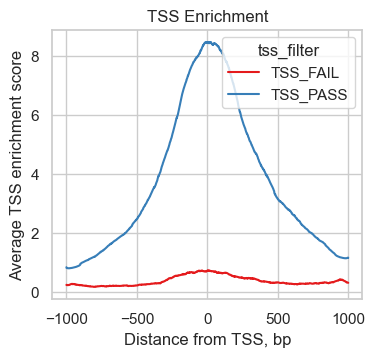

In [74]:
# Temporarily set different color palette
sns.set_palette(palette="Set1")
ac.pl.tss_enrichment(tss, color="tss_filter")
# reset color palette
sns.set_palette(palette="tab10")

We can see, how the 451 cells with low TSS scores show a much reduced enrichment of fragments around the TSS compared to high quality cells indicating a lower signal to noise ratio.

Let's print the object we created so far and double check that all QC scores were added correctly.

In [75]:
atac

AnnData object with n_obs × n_vars = 16934 × 154027
    obs: 'scDblFinder_score', 'AMULET_pVal', 'AMULET_qVal', 'AMULET_negLog10qVal', 'n_features_per_cell', 'total_fragment_counts', 'log_total_fragment_counts', 'nucleosome_signal', 'nuc_signal_filter', 'tss_score'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'atac', 'files'

Now, let's save the object before we filter out low quality cells.

In [77]:
# save after calculation of QC metrics
atac.write_h5ad("output/atac_qc_metrics.h5ad")

## Filtering cells

The value range of QC metrics can vary from sample to sample. Therefore, we recommend plotting quality metrics in multiple ways to get a good feeling for sensible thresholds to filter out outliers and low quality cells.

In [11]:
# Reload from file if needed
# atac = sc.read_h5ad("output/atac_qc_metrics.h5ad")

### Upper bound QC thresholds

First, we plot the full range of QC metrics to identify barcodes with unrealistically high total fragment counts or TSS scores or undesired high nucleosome signals. We already added lines for suitable thresholds in the following plots which we identified by looking at the output before.

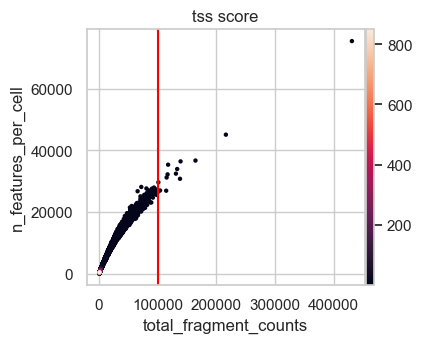

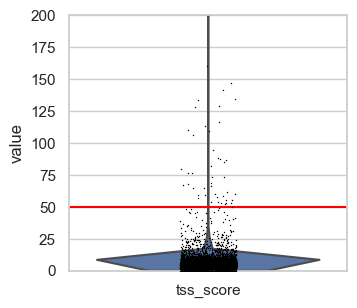

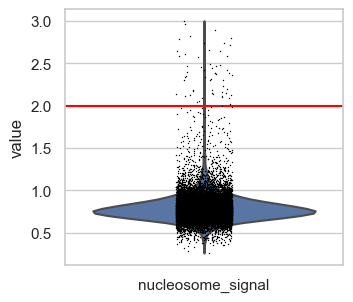

In [12]:
# Set thresholds for upper boundaries.
# These were identified by looking at the plots in this code cell before.
total_count_upper = 100000
tss_upper = 50
nucleosome_signal_upper = 2


# Plot total counts of fragments & features colored by TSS score
p1 = sc.pl.scatter(
    atac,
    x="total_fragment_counts",
    y="n_features_per_cell",
    size=40,
    color="tss_score",
    show=False,  # so that funstion output axis object where threshold line can be drawn.
)
p1.axvline(x=total_count_upper, c="red")  # Add vertical line

# tss.score
p2 = sc.pl.violin(atac, "tss_score", show=False)
p2.set_ylim(0, 200)  # zooming in a little to
p2.axhline(y=tss_upper, c="red")  # Add horizontal line

# nucleosome signal
p3 = sc.pl.violin(atac, "nucleosome_signal", show=False)
p3.axhline(y=nucleosome_signal_upper, c="red")

plt.show()

We define upper boundaries, such that only extreme outliers are excluded:
- `total_count_upper = 100000`
- `tss_upper = 50`
- `nucleosome_signal_upper = 2`


Note that the number of features is closely related by the number of total fragment counts and therefore extreme values for this QC metric excluded as well. Also, in principle a high TSS score is positive, but extremely high values are likely artifacts. This is also supported by the first scatter plot, where the highest TSS score corresponds to a barcode with very low fragment count and number of features.

### Lower bound QC thresholds

To identify the lower bounds of QC metrics, we create one of the most common visualizations in scATAC data to identify empty droplets and/or low quality cells. This is a scatter plot showing the TSS score over the log of the total counts.

We also added lines of suitable thresholds that we identified by looking at this and additional plots shown below.

In [13]:
# upper TSS score boundary for plotting
plot_tss_max = 20

# Suggested thresholds (before log transform)
count_cutoff_lower = 1500
lcount_cutoff_upper = 100000
tss_cutoff_lower = 1.5

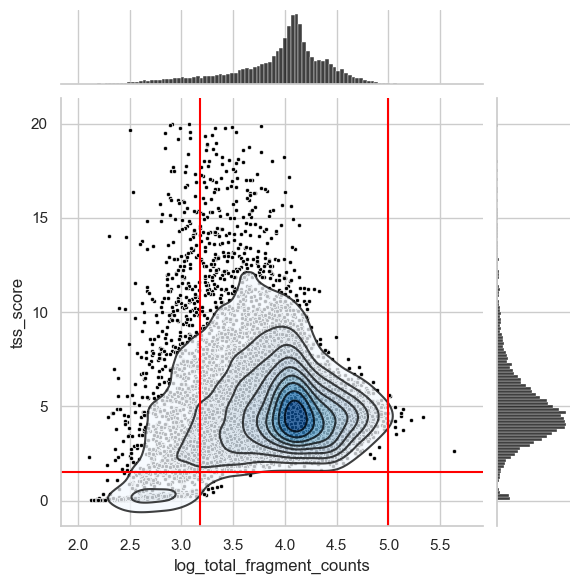

In [14]:
# Scatter plot & histograms
g = sns.jointplot(
    data=atac[(atac.obs["tss_score"] < plot_tss_max)].obs,
    x="log_total_fragment_counts",
    y="tss_score",
    color="black",
    marker=".",
)
# Density plot including lines
g.plot_joint(sns.kdeplot, fill=True, cmap="Blues", zorder=1, alpha=0.75)
g.plot_joint(sns.kdeplot, color="black", zorder=2, alpha=0.75)

# Lines thresholds
plt.axvline(x=np.log10(count_cutoff_lower), c="red")
plt.axvline(x=np.log10(lcount_cutoff_upper), c="red")
plt.axhline(y=tss_cutoff_lower, c="red")

plt.show()

There is a distinct cluster of low quality cells in the bottom left corner that we filter out through the TSS score threshold of 1.5. Also, we cut the long left tail of the distribution of total counts per cell. Identifying an ideal threshold for this is sometimes not straightforward. Therefore, we suggest to generate additional plots that can help to find a suitable value.

As with scRNA data, we might need to optimize thresholds in an iterative process, after we went through downstream processing steps and observe too many low quality cells still being present or a cell type with an expected low number of counts/features missing.


For now, we generate additional histograms of the raw total count values and zoom into the lower tail of the distribution.

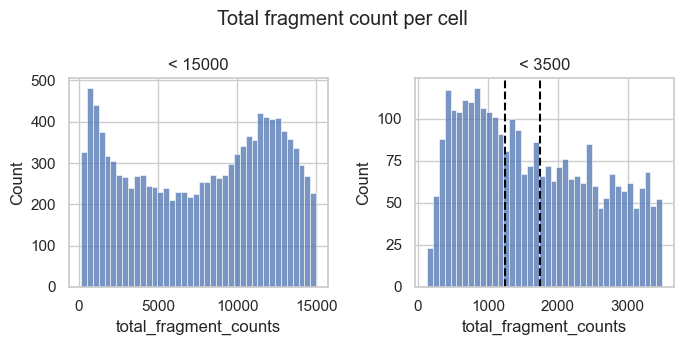

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))

p1 = sns.histplot(
    atac.obs.loc[atac.obs["total_fragment_counts"] < 15000],
    x="total_fragment_counts",
    bins=40,
    ax=axs[0],
)
p1.set_title("< 15000")

p2 = sns.histplot(
    atac.obs.loc[atac.obs["total_fragment_counts"] < 3500],
    x="total_fragment_counts",
    bins=40,
    ax=axs[1],
)
p2.set_title("< 3500")
p2.axvline(x=1250, c="black", linestyle="--")
p2.axvline(x=1750, c="black", linestyle="--")

plt.suptitle("Total fragment count per cell")

plt.tight_layout()
plt.show()

We observe a peak of barcodes with a low number of total counts that likely represent low quality barcodes. Based on the histogram to the right we could choose a threshold of about 1250 to 1750 to remove this peak.

Let's also get an idea for the number of features that barcodes with a total number of fragments in that range have. We added lines for a total fragment count of 1500, which represents an intermediate value of the suggested thresholds above.

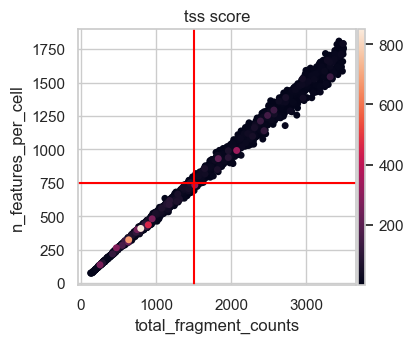

In [16]:
# Scatter plot total fragment count by number of features

n_feature_cutoff = 750  # added after looking at this plot

p2 = sc.pl.scatter(
    atac[atac.obs.total_fragment_counts < 3500],
    x="total_fragment_counts",
    y="n_features_per_cell",
    size=100,
    color="tss_score",
    show=False,
)
p2.axvline(x=count_cutoff_lower, c="red")
p2.axhline(y=n_feature_cutoff, c="red")

plt.show()

This scatter plot shows a nearly perfect linear relationship of the total fragment count with the number of features per cell. Considering the total number of features in our data set of more than 150000, 750 features seems like a permissive lower bound for filtering not risking to remove too many cells of interest. Taking all this together we decide on a lower total count threshold of 1500.

### Perform filtering

To summarize the outcome of our analysis thresholds:
- Total number of fragment counts per cell: > 1500 and < 100000
- Number of features per cell: > 750 (corresponding to the total fragment counts of 1500)
- TSS score: > 1.5 and < 50
- Nucleosome signal: < 2

Muon provides useful functionality to filter on any column in the `.obs` slot.

In [17]:
print(f"Total number of cells: {atac.n_obs}")
mu.pp.filter_obs(
    atac,
    "total_fragment_counts",
    lambda x: (x >= 1500) & (x <= 100000),
)
print(f"Number of cells after filtering on total_fragment_counts: {atac.n_obs}")
mu.pp.filter_obs(atac, "n_features_per_cell", lambda x: x >= 750)
print(f"Number of cells after filtering on n_features_per_cell: {atac.n_obs}")

Total number of cells: 16934
Number of cells after filtering on total_fragment_counts: 15386
Number of cells after filtering on n_features_per_cell: 15377


In [18]:
mu.pp.filter_obs(
    atac,
    "tss_score",
    lambda x: (x >= 1.5) & (x <= 50),
)
print(f"Number of cells after filtering on tss_score: {atac.n_obs}")
mu.pp.filter_obs(atac, "nucleosome_signal", lambda x: x <= 2)
print(f"Number of cells after filtering on nucleosome_signal: {atac.n_obs}")

Number of cells after filtering on tss_score: 15339
Number of cells after filtering on nucleosome_signal: 15286


## Filtering features

Lastly, we filter out features present in only a very low number of cells. These mostly add noise and computational resources needed in our downstream analysis. 

Depending on the scATAC processing workflow filtering of features is done either on a minimum absolute number of cells, a percentage of cells or a total number of features (e.g. the most accessible ones).

Let us do a little thought experiment to decide on a suitable threshold of a minimum number of cells a feature should be present. Let's say we would like to analyze a rare cell state, that makes up about 2% of our entire cell population. Considering that scATAC data has a high level of random drop outs, we assume features specific to this cell state to be detected in only 5% of the time. Therefore, on average we assume to detect this feature in about 5% of the 2% of the total number of cells. In our case with a data set of about 15000 cells, that would mean we expect cell state relevant features to be present in only 15 cells.

This threshold is also in the range of a general minimum of cell where a feature should be present and there are enough observations to allow downstream methods to pick up meaningful signals.

Here we choose this threshold, but keep in mind in case you are not interested in rare cell types or states, it might also improve your analysis to reduce the number of features to e.g. being present in at least 1% of the cells.

As with filtering cells, muon provides functionality to filter features as well.

In [198]:
mu.pp.filter_var(atac, "n_cells_by_counts", lambda x: x >= 15)

To ensure we keep a version of the raw counts we save them as a separate layer.

In [199]:
atac.layers["counts"] = atac.X

In [200]:
atac

AnnData object with n_obs × n_vars = 15286 × 154015
    obs: 'scDblFinder_score', 'AMULET_pVal', 'AMULET_qVal', 'AMULET_negLog10qVal', 'n_features_per_cell', 'total_fragment_counts', 'log_total_fragment_counts', 'nucleosome_signal', 'nuc_signal_filter', 'tss_score'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'atac', 'files'
    layers: 'counts'

Lastly, we save the filtered adata object for dimensionality reduction described in the next chapter.

In [201]:
atac.write_h5ad("output/atac_qc_filtered.h5ad")

## Key takeaways

To perform quality control on single-cell ATAC-sequencing data we recommend:

1. Use two orthogonal methods for robust doublet scoring leveraging the count distribution of simulated doublets as well as the number of genomic positions with more than two counts. Keep in mind that the latter requires a sufficient sequencing depth (> 10-15k reads per cell).

2. Use the total number of fragments, the number of features and scATAC- specific metrics like the transcription start site (TSS) enrichment score and the nucleosome signal to identify low quality cells. Remove barcodes with extreme values in any of the QC metrics (mostly upper bound thresholds). Remove the majority of low-quality cells mostly represented by a low total number of fragments combined with a low TSS enrichment score per cell.

3. Filter features considering the total number of cells in the data set and the objective of the analysis. If no rare cell states are of interest, features can be filtered to be present in at least 1% of the cells. If rare cell populations are of interest consider using a minimal number of cells that features should be detected in.

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: atac
```




## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Christopher Lance
* Laura Martens

### Reviewers

* Lukas Heumos
* Anna Schaar